In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
HOBO_low = pd.read_csv("HOBO\Group3-Low.csv", encoding="windows-1252")
HOBO_mid = pd.read_csv("HOBO\Group3-Mid.csv", encoding="windows-1252")
HOBO_top = pd.read_csv("HOBO\Group3-Top.csv", encoding="windows-1252")
CUBE = CUBE = pd.read_excel("CUBE\Group 3-Cube.xlsx")
results_1A = pd.read_csv("results_TOP.csv")

In [13]:
v_a_low = HOBO_low.iloc[:, 3]
v_a_mid = HOBO_mid.iloc[:, 3]
v_a_top = HOBO_top.iloc[:, 3]
t_mean_op = results_1A.iloc[:,6]
Date_Time = HOBO_mid.iloc[:, 0]

In [17]:
def draught_rate_comfort(v_ave, times, t_op, interval):

    DR_standards = np.zeros((len(v_ave), 4))
    cols = ["Draught Rate", "ASHRAE Standard", "ISO 7730 Standard", "Date/Time"]
    DR_standards = pd.DataFrame(DR_standards, columns=cols)

    for i in range(0, len(v_ave-interval), interval):
        v_sum_squared = 0
        v_rms = 0
        for j in range(interval):
            if i+j == len(v_ave-interval)-1:
                v = max(v_ave[i+j], 0.05)
                v_sum_squared += v*v
                v_rms = ((1/(j+1))*v_sum_squared)**0.5
                break
            v = max(v_ave[i+j], 0.05)
            v_sum_squared += v*v
        v_rms = ((1/interval)*v_sum_squared)**0.5
    
        for j in range(interval):
            if i+j == len(v_ave-interval)-1:
                v = max(v_ave[i+j], 0.05)
                TU = v_rms/v_ave[i+j]
                DR_standards.iloc[i+j,0] = (34 - t_op[i+j])*((v-0.05)**0.62)*(0.37*v*TU+3.14) 
                DR_standards.iloc[i+j,3] = times[i+j]
                break
            v = max(v_ave[i+j], 0.05)
            TU = v_rms/v_ave[i+j]
            DR_standards.iloc[i+j,0] = (34 - t_op[i+j])*((v-0.05)**0.62)*(0.37*v*TU+3.14)
            DR_standards.iloc[i+j,3] = times[i+j]

    for k in range(len(v_ave)):
        if DR_standards.iloc[k,0] <= 10:
            DR_standards.iloc[k,2] = "Cat I"
        elif DR_standards.iloc[k,0] <= 20:
            DR_standards.iloc[k,2] = "Cat II"
        elif DR_standards.iloc[k,0] <= 30:
            DR_standards.iloc[k,2] = "Cat III"
        else:
            DR_standards.iloc[k,2] = "X"

    for k in range(len(v_ave)):
        if DR_standards.iloc[k,0] <= 20:
            DR_standards.iloc[k,1] = "ok"
        else:
            DR_standards.iloc[k,1] = "X"

    return DR_standards

C:\Users\aarne\AppData\Local\Temp\ipykernel_11088\3313833344.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3/14/2025 9:15' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  DR_standards.iloc[i+j,3] = times[i+j]
C:\Users\aarne\AppData\Local\Temp\ipykernel_11088\3313833344.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Cat I' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  DR_standards.iloc[k,2] = "Cat I"
C:\Users\aarne\AppData\Local\Temp\ipykernel_11088\3313833344.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ok' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  DR_standards.iloc[k,1] = "ok"


TypeError: cannot do slice indexing on RangeIndex with these indexers [900.125] of type float

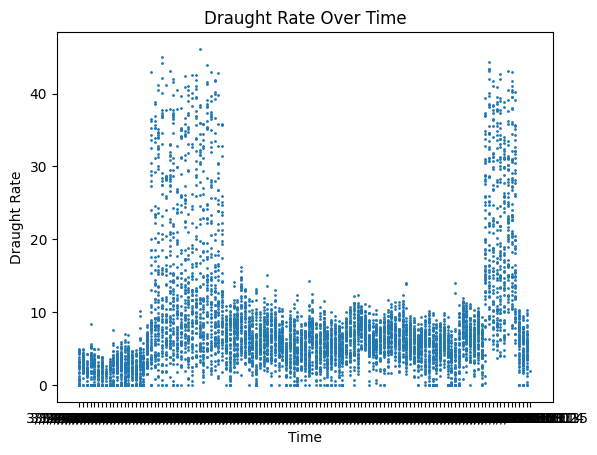

In [ ]:
dr_results = draught_rate_comfort(v_a_mid, Date_Time, t_mean_op, 60)
ISO_7730_red = pd.concat([dr_results[dr_results["ISO 7730 Standard"] == "Cat II"], dr_results[dr_results["ISO 7730 Standard"] == "Cat III"],dr_results[dr_results["ISO 7730 Standard"] == "X"]])
ASHRAE_red = dr_results[dr_results["ASHRAE Standard"] == "X"]

ISO_7730_red.to_csv("ISO_7730_red_DR.csv")
ASHRAE_red.to_csv("ASHRAE_red_DR.csv")

draught_rate = dr_results.iloc[:,0]

step = int(len(draught_rate) / 8)
plt.scatter(dr_results.iloc[:,3], draught_rate, s=1)
plt.title("Draught Rate Over Time")
plt.xlabel("Time")
plt.ylabel("Draught Rate")
plt.xticks(dr_results.iloc[:,3][::step], rotation=45)
plt.tight_layout()
plt.show()

print(ISO_7730_red)
print(ASHRAE_red)

In [19]:
Tpr_north = CUBE.iloc[:,4]
Tpr_south = CUBE.iloc[:,6]
Tpr_east = CUBE.iloc[:,5]
Tpr_west = CUBE.iloc[:,7]
Tpr_up = CUBE.iloc[:,3]
Tpr_down = CUBE.iloc[:,8]
Time = CUBE.iloc[:,0]

In [23]:
def radiant_temperature_asymmetry_comfort(n, s, e, w, u, d, times):
    DT_ns = n - s
    DT_ew = e - w
    DT_ud = u - d
    
    ISO_7730_warm_ns = []
    ISO_7730_cold_ns = []
    ASHRAE_warm_ns = []
    ASHRAE_cold_ns = []

    ISO_7730_warm_ew = []
    ISO_7730_cold_ew = []
    ASHRAE_warm_ew = []
    ASHRAE_cold_ew = []

    ISO_7730_warm_ud = []
    ISO_7730_cold_ud = []
    ASHRAE_warm_ud = []
    ASHRAE_cold_ud = []

    for i in range(len(DT_ns)):
        if DT_ns[i] > -10:
            ISO_7730_cold_ns.append("Cat I, II")
            ASHRAE_cold_ns.append("OK")
        elif DT_ns[i] > -13:
            ISO_7730_cold_ns.append("Cat III")
        else:
            ISO_7730_cold_ns.append("X")
            ASHRAE_cold_ns.append("X")

        if DT_ns[i] < 23:
            ISO_7730_warm_ns.append("Cat I, II")
            ASHRAE_warm_ns.append("OK")
        elif DT_ns[i] < 35:
            ISO_7730_warm_ns.append("Cat III")
        else:
            ISO_7730_warm_ns.append("X")
            ASHRAE_warm_ns.append("X")

    # Looping through each element in DT_ew
    for i in range(len(DT_ew)):  
        if DT_ew[i] > -10:
            ISO_7730_cold_ew.append("Cat I, II")
            ASHRAE_cold_ew.append("OK")
        elif DT_ew[i] > -13:
            ISO_7730_cold_ew.append("Cat III")
        else:
            ISO_7730_cold_ew.append("X")
            ASHRAE_cold_ew.append("X")

        if DT_ew[i] < 23:
            ISO_7730_warm_ew.append("Cat I, II")
            ASHRAE_warm_ew.append("OK")
        elif DT_ew[i] < 35:
            ISO_7730_warm_ew.append("Cat III")
        else:
            ISO_7730_warm_ew.append("X")
            ASHRAE_warm_ew.append("X")

    # Looping through each element in DT_ud
    for i in range(len(DT_ud)):  
        if DT_ud[i] > -14:
            ISO_7730_cold_ud.append("Cat I, II")
            ASHRAE_cold_ud.append("OK")
        elif DT_ud[i] > -18:
            ISO_7730_cold_ud.append("Cat III")
        else:
            ISO_7730_cold_ud.append("X")
            ASHRAE_cold_ud.append("X")

        if DT_ud[i] < 5:
            ISO_7730_warm_ud.append("Cat I, II")
            ASHRAE_warm_ud.append("OK")
        elif DT_ud[i] < 7:
            ISO_7730_warm_ud.append("Cat III")
        else:
            ISO_7730_warm_ud.append("X")
            ASHRAE_warm_ud.append("X")

    result = np.column_stack([times, DT_ns, ISO_7730_warm_ns, ISO_7730_cold_ns, ASHRAE_warm_ns, ASHRAE_cold_ns,
              DT_ew, ISO_7730_warm_ew, ISO_7730_cold_ew, ASHRAE_warm_ew, ASHRAE_cold_ew,
              DT_ud, ISO_7730_warm_ud, ISO_7730_cold_ud, ASHRAE_warm_ud, ASHRAE_cold_ud])
    
    cols = ["Time",
    "DT_ns", "ISO_7730_warm_ns", "ISO_7730_cold_ns", "ASHRAE_warm_ns", "ASHRAE_cold_ns",
    "DT_ew", "ISO_7730_warm_ew", "ISO_7730_cold_ew", "ASHRAE_warm_ew", "ASHRAE_cold_ew",
    "DT_ud", "ISO_7730_warm_ud", "ISO_7730_cold_ud", "ASHRAE_warm_ud", "ASHRAE_cold_ud"
    ]

    df = pd.DataFrame(result, columns=cols)
    
    return df

In [ ]:
results_asymmetry = radiant_temperature_asymmetry_comfort(Tpr_north, Tpr_south, Tpr_east, Tpr_west, Tpr_up, Tpr_down, Time)
ISO_7730_red_Tr = pd.concat([
    results_asymmetry[(results_asymmetry["ISO_7730_warm_ns"] == "Cat III") | (results_asymmetry["ISO_7730_cold_ns"] == "Cat III")],
    results_asymmetry[(results_asymmetry["ISO_7730_warm_ew"] == "Cat III") | (results_asymmetry["ISO_7730_cold_ew"] == "Cat III")],
    results_asymmetry[(results_asymmetry["ISO_7730_warm_ud"] == "Cat III") | (results_asymmetry["ISO_7730_cold_ud"] == "Cat III")],
    results_asymmetry[(results_asymmetry["ISO_7730_warm_ns"] == "X") | (results_asymmetry["ISO_7730_cold_ns"] == "X")],
    results_asymmetry[(results_asymmetry["ISO_7730_warm_ew"] == "X") | (results_asymmetry["ISO_7730_cold_ew"] == "X")],
    results_asymmetry[(results_asymmetry["ISO_7730_warm_ud"] == "X") | (results_asymmetry["ISO_7730_cold_ud"] == "X")]
])

print(ISO_7730_red_Tr)

ASHRAE_red_Tr = pd.concat([
    results_asymmetry[(results_asymmetry["ASHRAE_warm_ns"] == "X") | (results_asymmetry["ASHRAE_cold_ns"] == "X")],
    results_asymmetry[(results_asymmetry["ASHRAE_warm_ew"] == "X") | (results_asymmetry["ASHRAE_cold_ew"] == "X")],
    results_asymmetry[(results_asymmetry["ASHRAE_warm_ud"] == "X") | (results_asymmetry["ASHRAE_cold_ud"] == "X")]
])

ISO_7730_red_Tr.to_csv("ISO_7730_red_Tr.csv")
ASHRAE_red_Tr.to_csv("ASHRAE_red_Tr.csv")

print(ASHRAE_red_Tr)
print(max(results_asymmetry["DT_ud"]))

Empty DataFrame
Columns: [Time, DT_ns, ISO_7730_warm_ns, ISO_7730_cold_ns, ASHRAE_warm_ns, ASHRAE_cold_ns, DT_ew, ISO_7730_warm_ew, ISO_7730_cold_ew, ASHRAE_warm_ew, ASHRAE_cold_ew, DT_ud, ISO_7730_warm_ud, ISO_7730_cold_ud, ASHRAE_warm_ud, ASHRAE_cold_ud]
Index: []
Empty DataFrame
Columns: [Time, DT_ns, ISO_7730_warm_ns, ISO_7730_cold_ns, ASHRAE_warm_ns, ASHRAE_cold_ns, DT_ew, ISO_7730_warm_ew, ISO_7730_cold_ew, ASHRAE_warm_ew, ASHRAE_cold_ew, DT_ud, ISO_7730_warm_ud, ISO_7730_cold_ud, ASHRAE_warm_ud, ASHRAE_cold_ud]
Index: []
0.9800000000000004
